In [1]:
import sys

parent_dir = 'Predict-Future-Sales'
p_sub = sys.path[0]

ride = ''
for path in p_sub.split('/'):
    if path != parent_dir:
        ride = ride + path + '/'
    else:
        ride = ride + path + '/'
        break
sys.path[0] = ride

import pathlib
import pickle
import datetime

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import torch
import matplotlib.pyplot as plt

from module.lino_module.preprocess import mode_of_freq, src_tgt_split

/Users/lino/opt/anaconda3/envs/for_pytorch/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 再帰的推論
### モデル一覧

In [2]:
dir_path = './models/models_wm/'  # Transformer Model
# dir_path = './models/models_wm_refit/'  # Transformer Model（Refit）
# dir_path = './models/models_ax/'  # Auxiliary Model

files = list(pathlib.Path(dir_path).glob('**/*'))
for idx, i in enumerate(files):
    print(f'Index: {idx}')
    print(str(i.name)[:-4])
    print()

Index: 0
epochs(100)seq(14)_d_model(16)_dilation(0)_src_tgt_seq((9, 9))_step_num(5)_daily(True)_weekday(True)_weekly(False)_monthly(True)_scaler(StandardScaler)_

Index: 1
epochs(100)seq(14)_d_model(16)_dilation(3)_src_tgt_seq((9, 9))_step_num(5)_daily(True)_weekday(True)_weekly(False)_monthly(True)_scaler(StandardScaler)_

Index: 2
epochs(100)seq(14)_d_model(16)_dilation(0)_src_tgt_seq((9, 9))_step_num(5)_daily(True)_weekday(True)_weekly(True)_monthly(False)_scaler(StandardScaler)_

Index: 3
epochs(100)seq(14)_d_model(16)_dilation(3)_src_tgt_seq((9, 9))_step_num(5)_daily(False)_weekday(False)_weekly(False)_monthly(False)_scaler(StandardScaler)_

Index: 4
epochs(100)seq(14)_d_model(16)_dilation(0)_src_tgt_seq((9, 9))_step_num(5)_daily(False)_weekday(True)_weekly(True)_monthly(False)_scaler(StandardScaler)_

Index: 5
epochs(100)seq(14)_d_model(16)_dilation(0)_src_tgt_seq((9, 9))_step_num(5)_daily(True)_weekday(True)_weekly(True)_monthly(True)_scaler(StandardScaler)_

Index: 6
epochs(100

## データの呼び出し

In [3]:
# モデルの呼び出し
index = 1
model_name = files[index].name[:-4]
file_path = dir_path + model_name + '.pkl'
with open(file_path, 'rb') as f:
    kw = pickle.load(f)

# キーワド引数の選定
step_num = kw['step_num']

# プロットの保存先を設定
img_path = './imgs/img_inference/'
if dir_path == './models/models_ax/':
    img_path = img_path[:-1] + '_ax/'

model_type = kw['model']._get_name()
print('model type: ', model_type, '\n model name:', model_name)

model type:  TransformerModel 
 model name: epochs(100)seq(14)_d_model(16)_dilation(3)_src_tgt_seq((9, 9))_step_num(5)_daily(True)_weekday(True)_weekly(False)_monthly(True)_scaler(StandardScaler)_


## 指定した日数を予測

In [4]:
from module.lino_module.inference import RecurrentInference
from module.lino_module.ploter import inference_ploter

# 画像の保存
saving = False
ds = kw['data']

## ４半期ごとの予測(2014,01〜)

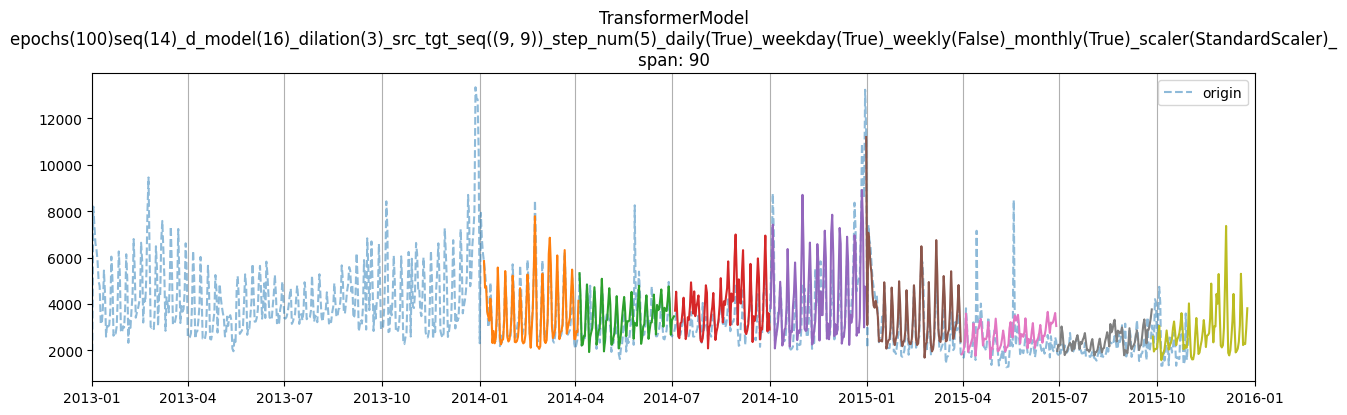

In [11]:
import matplotlib.dates as mdates

# 予測日数の設定
span = 90  # データの更新頻度日数
prediction_days = 365 + 10 * 30  # 推論日数 月数 日数
freq = int(prediction_days / step_num)  # 推論回数

# 描画と保存
plt.figure(figsize=(15, 4))
plt.plot(ds, label='origin', alpha=0.5, linestyle='dashed')

# 推論
cached = prediction_days
for _ in range(prediction_days//span + 1):
    data = ds[:-cached]  # 推論開始データ
    cached -= span
    self2 = RecurrentInference(**kw)
    self2(data)
    from_freq = self2.predict(span//step_num)
    plt.plot(from_freq)

xmin = datetime.datetime.strptime('2013-01', '%Y-%m')
xmax = datetime.datetime.strptime('2016-01', '%Y-%m')
plt.xlim([xmin,xmax])

locator = mdates.MonthLocator(bymonthday=1, interval=3)
plt.gca().xaxis.set_major_locator(locator)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
plt.grid(axis='x')
plt.legend()
plt.title(f'{model_type}\n'+ model_name + f'\nspan: {span}')
quarter_path = './imgs/img_quarter/'
if saving:
    plt.savefig(quarter_path + f'{model_type}' + model_name + f'span_{span}')
plt.show()

## 最新データから指定日後の予測推移

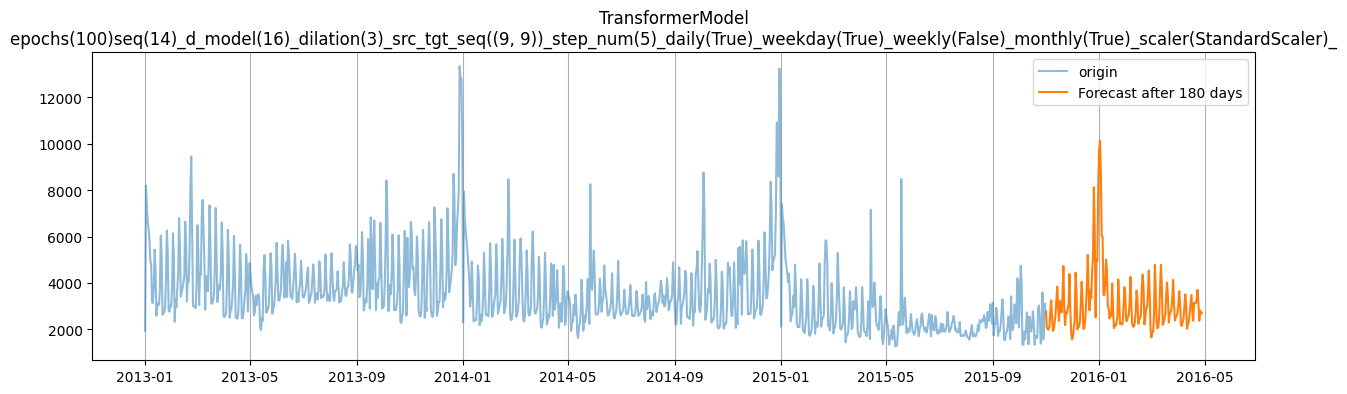

In [6]:
# 予測日数を設定
prediction_days = 180  # 推論日数
freq = int(prediction_days / step_num)  # 推論回数

# 推論
self = RecurrentInference(**kw)
self(ds)
plot_kw = {'ori': ds,
           'pred': self.predict(freq),
           'label': f'Forecast after {freq * step_num} days',
           'title': f'{model_type}\n'+ model_name,
           'figsize': (15, 4),
           'saving': saving,
           'path': img_path + model_name + f'freq_after_({freq}).png',}

# 描画と保存
inference_ploter(**plot_kw)

## 指定日前から最新データ日までの予測推移

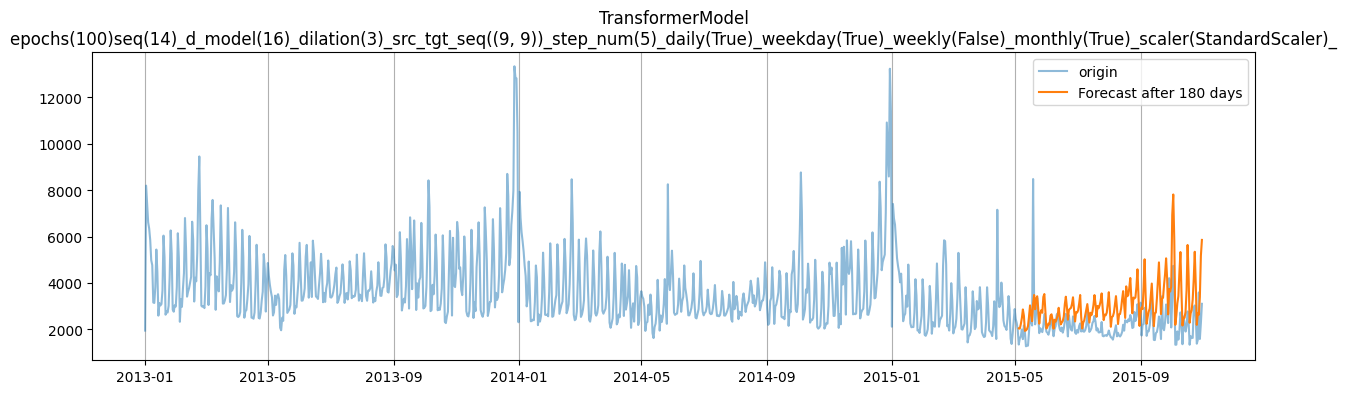

In [8]:
# 予測日数の設定
prediction_days = 180  # 推論日数
freq = int(prediction_days / step_num)  # 推論回数
data = ds[:-prediction_days]  # 推論開始データ
# 推論
self = RecurrentInference(**kw)
self(data)
plot_kw = {'ori': ds,
           'pred': self.predict(freq),
           'label': f'Forecast after {freq * step_num} days',
           'title': f'{model_type}\n'+ model_name,
           'figsize': (15, 4),
           'saving': saving,
           'path': img_path + model_name + f'freq_after_({freq}).png',}
# 描画と保存
inference_ploter(**plot_kw)

### 以下は推論用に作成したクラス

## Recurrent Inference Class

In [ ]:
import datetime

import pandas as pd
import numpy as np
import torch

from module.lino_module.preprocess import src_tgt_split

from typing import Tuple, Optional, Union
from numpy import ndarray
from pandas import DataFrame, Series, Timestamp
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from torch import Tensor


class RecurrentInference():
    """再起的に推論を行うクラス"""
    def __init__(self, data, model, seq, d_model, dilation, src_tgt_seq,
                 step_num, daily, weekday, weekly, monthly, scaler):
        """ Initializer
        引数:
            model: 訓練済みモデル
            seq: 訓練条件時の seq
            d_model: 訓練条件時の d_model
            dilation: 訓練条件時の dilation
            src_tgt_seq: 訓練条件時の src_tgt_seq,
            step_num: 一回の推論における予測日数
            daily: 訓練条件時の日付情報の有無
            weekday: 訓練条件時の曜日情報の有無
            weekly: 訓練条件時の週次情報の有無
            monthly: 訓練条件時の月次情報の有無
        """
        self.training_data: Series = data
        self.model: object = model
        self.seq: int = seq
        self.d_model: int = d_model
        self.dilation: int = dilation
        self.src_tgt_seq: Tuple[int] = src_tgt_seq
        self.step_num: int = step_num
        self.daily: bool = daily
        self.weekday: bool = weekday
        self.weekly: bool = weekly
        self.monthly: bool = monthly
        self.scaler:  Union[StandardScaler, MinMaxScaler] = scaler

        self.df: Optional[DataFrame] = None
        self.inferenced: Optional[Series] = None
        self.embedded: Optional[ndarray] = None
        self.latest_index: Optional[Timestamp] = None
        self.latest_data: Optional[float] = None

    def __call__(self, ds: Series):
        """入力データを登録
        引数:
            ds: 訓練データセット作成時に使用したシリーズ
            scaler: 訓練時に使用したスケーラー
        """
        fit_target = self.training_data.values.reshape(-1, 1)
        self.scaler = self.scaler().fit(fit_target)

        reshaped = ds.values.reshape(-1, 1)
        scaled_ds = self.scaler.transform(reshaped).reshape(-1)

        # 入力データから推論に持ちるデータフレームを生成
        self.df = pd.DataFrame(scaled_ds,
                               columns=['data'],
                               index=ds.index.tolist())
        # 推論結果を書くのするデータフレームを生成
        self.latest_index = ds.index[-self.step_num:]
        self.latest_data = ds[-self.step_num:]
        self.inferenced = pd.Series(self.latest_data, index=self.latest_index)

        if self.daily:
            self.df['daily'] = ds.index.day / 31
        if self.weekday:
            self.df['weekday'] = ds.index.weekday / 6
        if self.weekly:
            scaled_calendar = (ds.index.isocalendar().week - 1) / 44
            self.df['weekly'] = scaled_calendar.values
        if self.monthly:
            self.df['monthly'] = (ds.index.month - 1) / 11

    def predict(self, freq: int) -> Series:
        """推論用関数
        引数:
            freq: 再帰推論回数
        """
        for _ in range(freq):
            self.embedded = self.tde(self.df,
                                     self.seq,
                                     self.d_model,
                                     self.dilation)
            src, tgt = src_tgt_split(self.embedded, *self.src_tgt_seq)
            output = self.inference(self.model, src, tgt).reshape(-1)
            scaled = output[-self.step_num:]
            inversed = self.scaler.inverse_transform(scaled.reshape(-1, 1))
            inversed = inversed.reshape(-1)

            # 推論の追加
            self.latest_index += datetime.timedelta(self.step_num)
            inferenced = pd.Series(inversed, index=self.latest_index)
            self.inferenced = pd.concat((self.inferenced, inferenced))

            # datasetの更新
            latest_data = {'data': scaled}
            if self.daily:
                scaled_daily = self.latest_index.day / 31
                latest_data['daily'] = scaled_daily
            if self.weekday:
                scaled_weekday = self.latest_index.weekday / 6
                latest_data['weekday'] = scaled_weekday
            if self.weekly:
                scaled_weekly = (self.latest_index.isocalendar().week - 1) / 44
                latest_data['weekly'] = scaled_weekly
            if self.monthly:
                scaled_month = (self.latest_index.month - 1) / 11
                latest_data['monthly'] = scaled_month
            latest = pd.DataFrame(latest_data, index=self.latest_index)
            self.df = pd.concat((self.df, latest))
        return self.inferenced[self.step_num:]

    @classmethod
    def tde(self,
            df: DataFrame,
            seq: int,
            d_model: int,
            dilation: int
            ) -> ndarray:
        """Time delay Embedding
           入力データ末端のseq分からTDEデータを作成
        引数:
            df: [data, weekly, monthly]のカラムと Timestamp インデックスを持ったデータフレーム
            seq: 訓練条件時の seq
            d_model: 訓練条件時の d_model
            dilation: 訓練条件時の dilation
        """
        embeded = []
        for column in df.columns:
            trg = getattr(df, column)
            tded = self.tde_for_inference(trg, seq, d_model, dilation)
            embeded.append(tded.tolist())
        embeded = np.array(embeded).reshape(d_model*len(df.columns), -1)
        return embeded

    @classmethod
    def inference(self, model: object, src: Tensor, tgt: Tensor) -> ndarray:
        """推論関数
        """
        src = torch.from_numpy(src.astype(np.float32)).unsqueeze(0)
        tgt = torch.from_numpy(tgt.astype(np.float32)).unsqueeze(0)
        model.eval()
        if model._get_name() == 'WithAuxiliary':
            base, auxi = model(src, tgt)
            output = base.detach().numpy() + auxi.detach().numpy()
        else:
            output = model(src, tgt).detach().numpy()
        return output

    @classmethod
    def tde_for_inference(self, ds: Series, seq: int,
                          d_model: int, dilation: int) -> ndarray:
        for_array = []
        for i in range(d_model):
            if i != 0:
                for_array.append(ds[-seq - i*(dilation + 1): -i*(dilation + 1)])
            else:
                for_array.append(ds[-seq:])
        time_delay_embedded = np.array([j for j in reversed(for_array)])
        return time_delay_embedded
